AdaBoost Test Doğruluk: % 49.27
              precision    recall  f1-score   support

           0       0.39      0.42      0.40       549
           1       0.38      0.56      0.45       549
           2       0.41      0.40      0.41       549
           3       0.54      0.63      0.58       550
           4       0.70      0.37      0.49       550
           5       0.52      0.49      0.51       549
           6       0.70      0.57      0.63       550

    accuracy                           0.49      3846
   macro avg       0.52      0.49      0.50      3846
weighted avg       0.52      0.49      0.50      3846



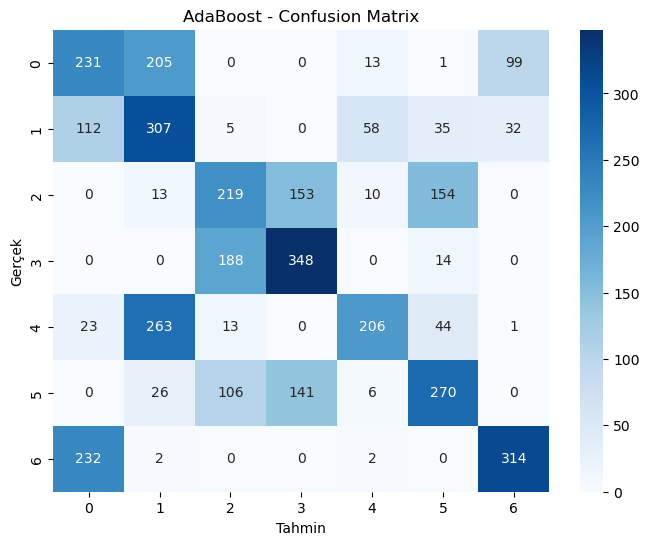

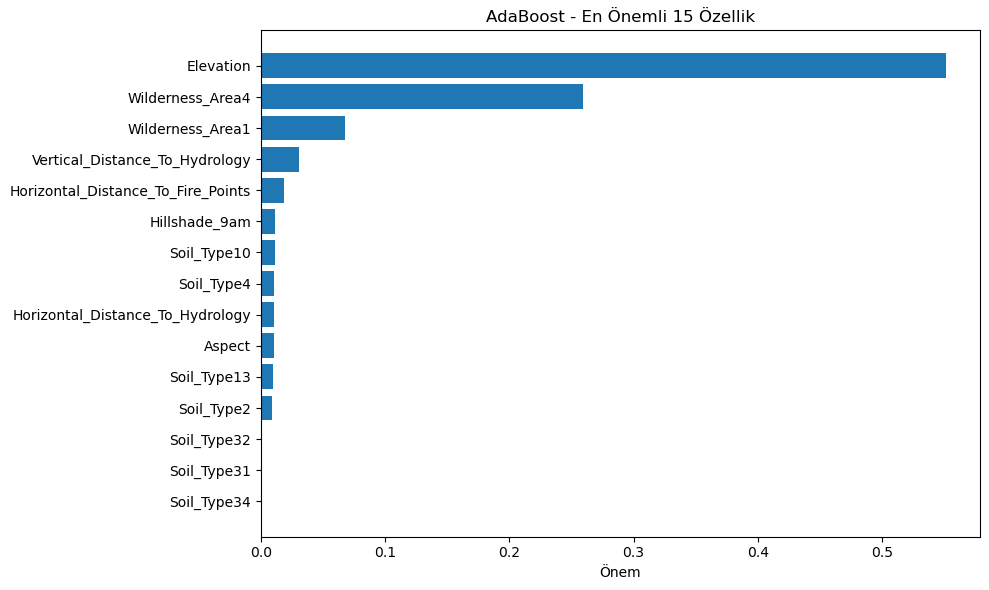

In [1]:
# Forest Cover Type - DENGELİ ADABOOST

import pandas as pd  # Veri okuma, DataFrame yönetimi ve işleme için pandas
import numpy as np   # Sayısal işlemler, array ve matematiksel hesaplamalar için numpy
from sklearn.model_selection import train_test_split  # Eğitim/test veri ayırma fonksiyonu
from sklearn.ensemble import AdaBoostClassifier       # AdaBoost algoritması (ensemble boosting) için
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report  # Model değerlendirme metrikleri
import matplotlib.pyplot as plt   # Grafik çizimi için temel matplotlib kütüphanesi
import seaborn as sns            # Gelişmiş görseller (özellikle heatmap) için seaborn
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

df = pd.read_csv("covtype.csv")  # 'covtype.csv' dosyasını pandas ile oku, df adlı DataFrame'e ata

n = df["Cover_Type"].value_counts().min()  
# Her bir sınıf ('Cover_Type') kaç örnek içeriyor bakılır, en az olanın adedi alınır.
# Amaç: Her sınıftan eşit örnek almak, dengesiz sınıf (class imbalance) problemini ortadan kaldırmak.

df_dengeli = df.groupby("Cover_Type", group_keys=False).apply(lambda x: x.sample(n=n, random_state=42))
# Veriyi 'Cover_Type' sütununa göre gruplar, her gruptan n tane satırı rastgele seçer.
# Böylece her sınıf tam eşit sayıda örnekle temsil edilir (dengeli veri seti elde edilir).
# random_state=42, seçimleri sabit ve tekrarlanabilir yapmak için.

X = df_dengeli.drop("Cover_Type", axis=1)  
# Tahmin etmeye çalışacağımız (hedef, target) sütunu çıkarıyoruz.
# Sadece modelde kullanılacak giriş (feature) sütunları kalıyor.

y = df_dengeli["Cover_Type"] - 1  
# Sınıf etiketlerini alıyoruz, -1 ile 0'dan başlatıyoruz.
# scikit-learn çoğu algoritmasında 0 tabanlı etiket ister, ayrıca hata riskini azaltır.

X_egitim, X_test, y_egitim, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Veriyi %80 eğitim, %20 test olacak şekilde bölüyoruz.
# stratify=y ile hem eğitimde hem testte sınıf dağılımı korunmuş olur.
# random_state=42 ise yine tekrarlanabilirliği garanti eder.

ada = AdaBoostClassifier(n_estimators=100, random_state=42)
# AdaBoost modelini oluşturuyoruz.
# n_estimators=100: 100 zayıf sınıflandırıcı (genelde decision stump) ile boosting yapacak.
# random_state=42 ile sonuçlar aynı kalır.

ada.fit(X_egitim, y_egitim)
# Modeli eğitim verisiyle eğitiyoruz. AdaBoost art arda zayıf sınıflandırıcılar kurup bunları birleştiriyor.

y_tahmin = ada.predict(X_test)
# Test setindeki verilerle tahmin yapıyoruz.
# Modelin performansını şimdi ölçebiliriz.

dogruluk = accuracy_score(y_test, y_tahmin)
# Doğruluk (accuracy) oranı hesaplanır. Kaç örnek doğru sınıflandırılmış, genel başarı oranı.

cm = confusion_matrix(y_test, y_tahmin)
# Confusion matrix (karışıklık matrisi): Her sınıfın doğru/yanlış tahmin edilme adetleri.
# Satırlar gerçek değerler, sütunlar modelin tahmini.

print("AdaBoost Test Doğruluk: %", round(dogruluk*100,2))
# Doğruluk oranını yüzde cinsinden ekrana yazdır.

print(classification_report(y_test, y_tahmin, zero_division=0))
# Her sınıf için precision, recall, f1-score ve destek (support) metriklerini detaylıca verir.
# zero_division=0, sıfıra bölme hatası çıkarsa 0 döndürür, kodun patlamasını engeller.

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
# confusion_matrix'i görsel olarak heatmap şeklinde çiz.
# annot=True: Karelerin içinde sayı yazsın.
# fmt='d': Tam sayı formatı.
# cmap="Blues": Mavi renk skalası (koyu renk daha yüksek sayıları gösterir).

plt.title("AdaBoost - Confusion Matrix")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.show()
# Grafik başlığını ve eksen isimlerini ayarla ve ekrana göster.

if hasattr(ada, "feature_importances_"):
    # AdaBoost, DecisionTree tabanlıysa (varsayılan) feature_importances_ özniteliğine sahiptir.
    importances = ada.feature_importances_
    # Özelliklerin modele katkı oranlarını (önemini) getirir.
    sorted_idx = np.argsort(importances)[::-1][:15]
    # En önemli 15 özelliği (büyükten küçüğe) sırala.
    plt.figure(figsize=(10,6))
    plt.barh(X.columns[sorted_idx][::-1], importances[sorted_idx][::-1])
    # Yatay çubuk grafik ile en önemli 15 özelliği göster.
    plt.xlabel("Önem")
    plt.title("AdaBoost - En Önemli 15 Özellik")
    plt.tight_layout()
    plt.show()
    # Grafik başlığını ayarla ve ekrana çizdir.

# Not: AdaBoost ile RandomForest’ın ana farkı:
# AdaBoost “hatalı” sınıflandırılan örneklere ağırlık verip onları düzeltmeye çalışır,
# RandomForest ise rastgele veri ve özellik seçerek birden fazla bağımsız ağaç kurar.
# AdaBoost genelde “daha basit modeller” üzerinden çalışır ve dengesiz veriyle çok verimli çalışmaz;
# o yüzden burada da önce veri dengeleniyor.
